In [1]:
pip install statsmodels


In [2]:
!pip install --upgrade scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 27.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import Image

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import datetime
import math
import calendar
from math import radians
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_selection import RFE
import statsmodels.api as sm

# `Reading and Understanding the Data`

In [4]:
# Loading the dataset
from google.colab import drive

drive.mount('/content/gdrive')

df = pd.read_csv('/content/gdrive/MyDrive/Python projects/fraudTrain.csv')

Mounted at /content/gdrive


In [5]:
# Let us check if there are null values in the dataset

df.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [6]:
# Including only relevant columns/features in a new dataframe

fraudTrain = df[['trans_date_trans_time','amt','gender','lat','long','city_pop','dob','merch_lat','merch_long','is_fraud']]
fraudTrain.head()

trans_date_trans_time     amt gender      lat      long  city_pop  \
0   2019-01-01 00:00:18    4.97      F  36.0788  -81.1781      3495   
1   2019-01-01 00:00:44  107.23      F  48.8878 -118.2105       149   
2   2019-01-01 00:00:51  220.11      M  42.1808 -112.2620      4154   
3   2019-01-01 00:01:16   45.00      M  46.2306 -112.1138      1939   
4   2019-01-01 00:03:06   41.96      M  38.4207  -79.4629        99   

          dob  merch_lat  merch_long  is_fraud  
0  1988-03-09  36.011293  -82.048315         0  
1  1978-06-21  49.159047 -118.186462         0  
2  1962-01-19  43.150704 -112.154481         0  
3  1967-01-12  47.034331 -112.561071         0  
4  1986-03-28  38.674999  -78.632459         0

> - #### Identifying Target Variable - is_fraud

In [7]:
# Converting columns to datetime for fraudTrain

fraudTrain.dob = pd.to_datetime(fraudTrain['dob'])
fraudTrain.trans_date_trans_time = pd.to_datetime(fraudTrain['trans_date_trans_time'])

In [8]:
# Creating a new column called Transaction date and converting into datetime

fraudTrain['Transaction_Date'] = pd.to_datetime(fraudTrain['trans_date_trans_time'], format='%Y:%M:%D').dt.date
fraudTrain.Transaction_Date = pd.to_datetime(fraudTrain['Transaction_Date'])

In [9]:
# Creating a new column called Transaction Time

fraudTrain['Transaction_Time'] = pd.to_datetime(fraudTrain['trans_date_trans_time'], format='%Y:%M:%D').dt.time

In [10]:
# Creating a new column called Age

fraudTrain['Age'] = round((fraudTrain['Transaction_Date'] - fraudTrain['dob'])/np.timedelta64(1, 'Y'))
fraudTrain.Age = fraudTrain.Age.astype('int')

In [11]:
fraudTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 13 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   trans_date_trans_time  1296675 non-null  datetime64[ns]
 1   amt                    1296675 non-null  float64       
 2   gender                 1296675 non-null  object        
 3   lat                    1296675 non-null  float64       
 4   long                   1296675 non-null  float64       
 5   city_pop               1296675 non-null  int64         
 6   dob                    1296675 non-null  datetime64[ns]
 7   merch_lat              1296675 non-null  float64       
 8   merch_long             1296675 non-null  float64       
 9   is_fraud               1296675 non-null  int64         
 10  Transaction_Date       1296675 non-null  datetime64[ns]
 11  Transaction_Time       1296675 non-null  object        
 12  Age                    12966

In [12]:
# Creating a function to calculate the Day of Week

def DoW(x):
    day = datetime.datetime.weekday(x)
    return (calendar.day_name[day])

fraudTrain['Day_of_Week'] = fraudTrain['Transaction_Date'].apply(DoW)

In [13]:
# # Creating a new column Month

fraudTrain['Month'] = pd.DatetimeIndex(fraudTrain.trans_date_trans_time).month

# Making Gender column binary

fraudTrain['gender'] = fraudTrain['gender'].map({'F':1, 'M':0})
fraudTrain['Day_of_Week'] = fraudTrain['Day_of_Week'].map({'Monday':1, 'Tuesday':2, 'Wednesday': 3, 'Thursday': 4,
                                                          'Friday':5, 'Saturday':6, 'Sunday': 7})

In [14]:
# Creating a function to calculate the distance between customer's base location and merchant location

def haversineDistance(lat1,lon1,lat2,lon2):
    Lat_Dist = radians(lat2 - lat1)
    Long_Dist = radians(lon2 - lon1)

    ans = (pow(math.sin(Lat_Dist / 2), 2) + pow(math.sin(Long_Dist / 2), 2) * math.cos(lat1) * math.cos(lat2));
    radius = 6371
    cal = 2 * math.asin(math.sqrt(ans))
    return radius * cal

Dist = []
for a,b,c,d in zip(fraudTrain['lat'], fraudTrain['long'], fraudTrain['merch_lat'], fraudTrain['merch_long']):
    Dist.append(haversineDistance(a,b,c,d))

fraudTrain['Dist'] = Dist
fraudTrain.head()

trans_date_trans_time     amt  gender      lat      long  city_pop  \
0   2019-01-01 00:00:18    4.97       1  36.0788  -81.1781      3495   
1   2019-01-01 00:00:44  107.23       1  48.8878 -118.2105       149   
2   2019-01-01 00:00:51  220.11       0  42.1808 -112.2620      4154   
3   2019-01-01 00:01:16   45.00       0  46.2306 -112.1138      1939   
4   2019-01-01 00:03:06   41.96       0  38.4207  -79.4629        99   

         dob  merch_lat  merch_long  is_fraud Transaction_Date  \
0 1988-03-09  36.011293  -82.048315         0       2019-01-01   
1 1978-06-21  49.159047 -118.186462         0       2019-01-01   
2 1962-01-19  43.150704 -112.154481         0       2019-01-01   
3 1967-01-12  47.034331 -112.561071         0       2019-01-01   
4 1986-03-28  38.674999  -78.632459         0       2019-01-01   

  Transaction_Time  Age  Day_of_Week  Month        Dist  
0         00:00:18   31            2      1   10.509708  
1         00:00:44   41            2      1   30.171468  
2         00:00:51   57            2      1  107.746268  
3         00:01:16   52            2      1   97.629363  
4         00:03:06   33            2      1   66.236025

In [15]:
# Dropping unnecessay columns

fraudTrain.drop(['trans_date_trans_time','Transaction_Date','Transaction_Time','dob',
                 'lat','long', 'merch_lat','merch_long'], axis=1, inplace=True)
fraudTrain.head()

amt  gender  city_pop  is_fraud  Age  Day_of_Week  Month        Dist
0    4.97       1      3495         0   31            2      1   10.509708
1  107.23       1       149         0   41            2      1   30.171468
2  220.11       0      4154         0   57            2      1  107.746268
3   45.00       0      1939         0   52            2      1   97.629363
4   41.96       0        99         0   33            2      1   66.236025

# `Exploratory Data Analysis`

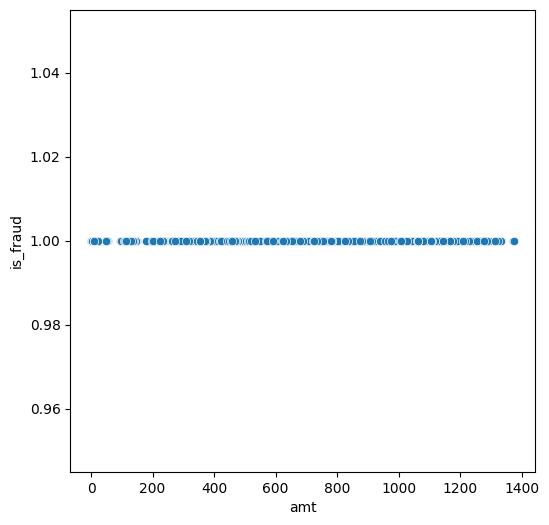

In [16]:
plt.figure(figsize = (6,6))
sns.scatterplot(data = fraudTrain[fraudTrain['is_fraud'] == 1], x = 'amt', y = 'is_fraud')
plt.show()

- Fraud happens at all cost

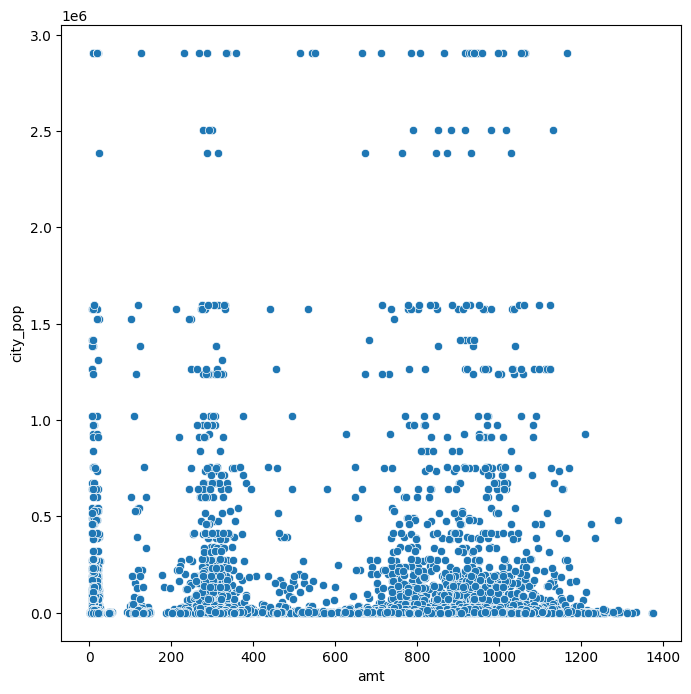

In [17]:
plt.figure(figsize = (8,8))
sns.scatterplot(data = fraudTrain[fraudTrain['is_fraud'] == 1], x = 'amt', y = 'city_pop')
plt.show()

- No clear relation between city population and the amount of spending.

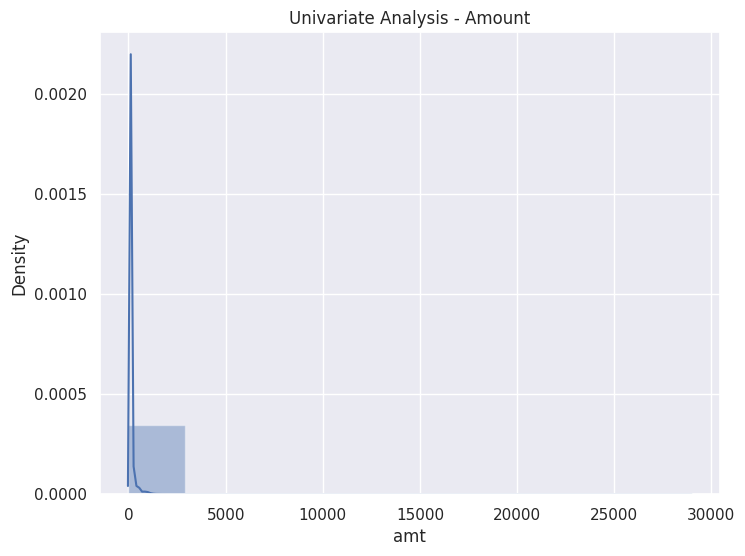

In [18]:
# Checking for amount distribution

plt.figure(figsize = [8,6])
sns.set_theme()
sns.distplot(fraudTrain.amt, bins = 10, kde = True)
plt.title('Univariate Analysis - Amount')
plt.show()

In [19]:
fraudTrain['amt'] = np.log(fraudTrain['amt'])

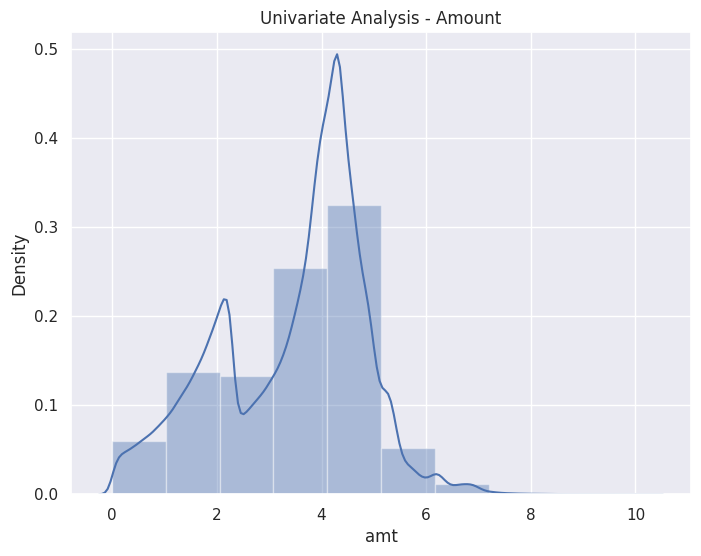

In [20]:
plt.figure(figsize = [8,6])
sns.set_theme()
sns.distplot(fraudTrain['amt'], bins = 10, kde = True)
plt.title('Univariate Analysis - Amount')
plt.show()

- After treating skewness, the amount column is more normally distributed

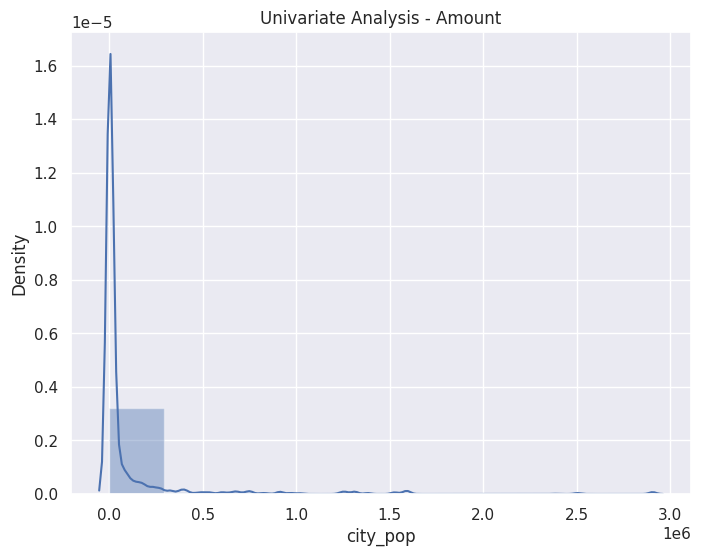

In [21]:
# Checking for population distribution

plt.figure(figsize = [8,6])
sns.set_theme()
sns.distplot(fraudTrain['city_pop'], bins = 10, kde = True)
plt.title('Univariate Analysis - Amount')
plt.show()

In [22]:
fraudTrain['city_pop'] = np.log(fraudTrain['city_pop'])

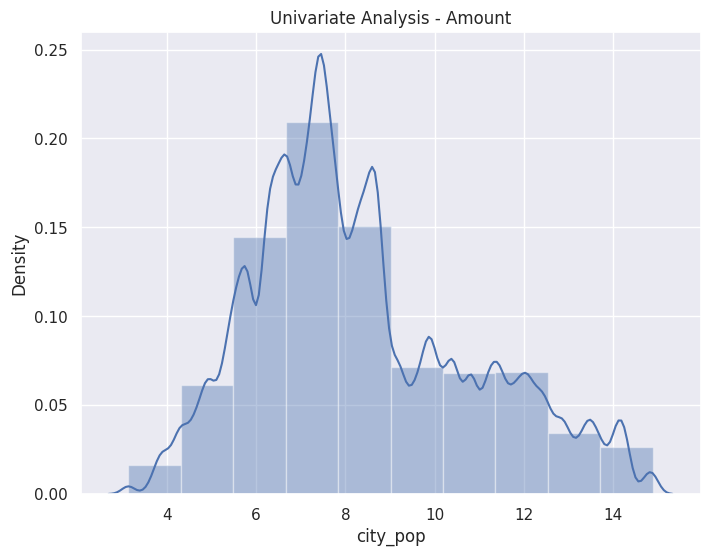

In [23]:
# Checking for population distribution after treating skewness

plt.figure(figsize = [8,6])
sns.set_theme()
sns.distplot(fraudTrain['city_pop'], bins = 10, kde = True)
plt.title('Univariate Analysis - Amount')
plt.show()

In [24]:
# The skewness for city population has also been handled

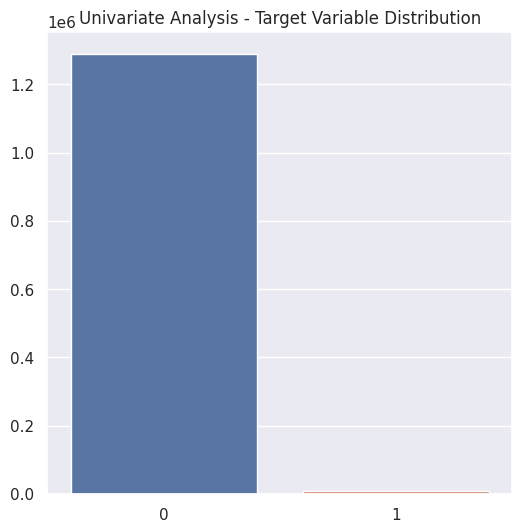

In [25]:
# Let us see the Target Variable distribution across the dataset

x = [0, 1]
y = [fraudTrain.is_fraud.value_counts()[0],fraudTrain.is_fraud.value_counts()[1]]

plt.figure(figsize = [6,6])
ax = sns.barplot(x = x, y = y)
plt.title('Univariate Analysis - Target Variable Distribution')
plt.show()

- The data shows clear imbalance in the target variable which needs to be handled by sampling methods

Text(0.5, 1.0, 'Univariate Analysis - Gender Distribution')

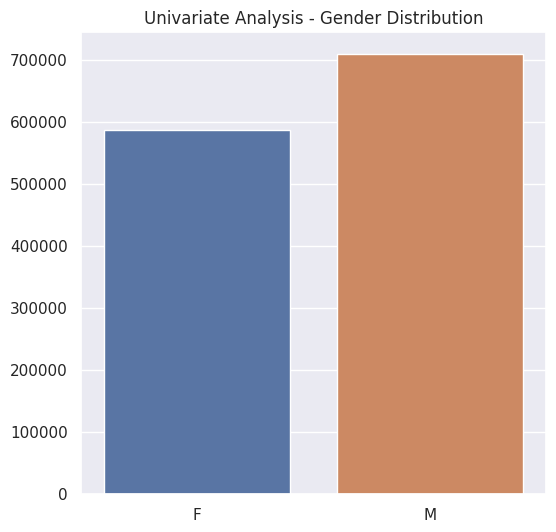

In [26]:
# Let us see the Gender distribution across the dataset

x = ['F', 'M']
y = [fraudTrain.gender.value_counts()[0], fraudTrain.gender.value_counts()[1]]

plt.figure(figsize = [6,6])
ax = sns.barplot(x = x, y = y)
plt.title('Univariate Analysis - Gender Distribution')

# `Train/Test Data Splitting`

In [27]:
y = fraudTrain.pop('is_fraud')
X = fraudTrain

In [28]:
from sklearn import model_selection

# To handle data imbalance while splitting, using the stratify method

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify = y, random_state=42)

In [29]:
#Confirming shapes of the test and train datasets

X_train.shape, X_test.shape

((972506, 7), (324169, 7))

## Scaling of variables for Logistic Regression

In [30]:
fraudTrain.columns

Index(['amt', 'gender', 'city_pop', 'Age', 'Day_of_Week', 'Month', 'Dist'], dtype='object')

In [31]:
# Making a copy of the X_train and scaling it as that is specific only to Logistic Regression

X_train_lr = X_train.copy()

scaler = MinMaxScaler()
X_train_lr[['amt', 'gender', 'city_pop', 'Age', 'Day_of_Week', 'Month', 'Dist']] = scaler.fit_transform(X_train[['amt','gender', 'city_pop', 'Age', 'Day_of_Week', 'Month', 'Dist']])
X_train_lr.head()

amt  gender  city_pop       Age  Day_of_Week     Month      Dist
267436  0.482372     0.0  0.448670  0.353659     1.000000  0.363636  0.376031
233159  0.251400     1.0  0.230283  0.463415     0.833333  0.272727  0.642221
430072  0.441626     0.0  0.470635  0.560976     0.666667  0.545455  0.718947
236662  0.474693     1.0  0.698418  0.414634     1.000000  0.272727  0.510120
450357  0.462170     0.0  0.477590  0.841463     0.666667  0.545455  0.540952

In [32]:
# Confirming if scaling has worked

X_train_lr.describe()

amt         gender       city_pop            Age  \
count  972506.000000  972506.000000  972506.000000  972506.000000   
mean        0.338391       0.546699       0.444523       0.390205   
std         0.135778       0.497815       0.208761       0.212136   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.221962       0.000000       0.295607       0.231707   
50%         0.377921       1.000000       0.397163       0.365854   
75%         0.432530       1.000000       0.577530       0.524390   
max         1.000000       1.000000       1.000000       1.000000   

         Day_of_Week          Month           Dist  
count  972506.000000  972506.000000  972506.000000  
mean        0.511807       0.467545       0.473872  
std         0.366377       0.310577       0.206361  
min         0.000000       0.000000       0.000000  
25%         0.166667       0.181818       0.314929  
50%         0.500000       0.454545       0.488222  
75%         0.833333       0.727273       0.640732  
max         1.000000       1.000000       1.000000

# `Model Building and Hyperparameter Tuning`

> The algorithms that will be used in order to create classification models that would be sensitive to detecting fraudulent transactions are:
- Logistic Regression
- Decision Trees
- Random Forest
- XGBoost

> Each algorithm will have an unsampled model and will then be compared by using sampling methods - SMOTE and ADASYN
> Let us proceed with the model building part in the order mentioned above:

## 1.1 Logistic Regression - Unsampled

In [33]:
logreg_unsampled = LogisticRegression().fit(X_train_lr,y_train)

#### Hyperparameter tuning using Grid Search CV

In [34]:
from sklearn.model_selection import GridSearchCV

In [35]:
params_lr = {
    'C': np.logspace(-3,3,7),
    'penalty': ['l2']
}

grid_search_1 = GridSearchCV(estimator=logreg_unsampled,
                    param_grid=params_lr,
                    cv=4,
                    n_jobs=-1, verbose=1,
                    scoring='recall')

In [36]:
%%time
grid_search_1.fit(X_train_lr, y_train)

Fitting 4 folds for each of 7 candidates, totalling 28 fits
CPU times: user 1.95 s, sys: 1.07 s, total: 3.02 s
Wall time: 32.7 s


GridSearchCV(cv=4, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l2']},
             scoring='recall', verbose=1)

In [37]:
grid_search_1.best_score_

0.0

# `Model Evaluation`
> The metric used to evaluate the models is - Recall
- Recall attempts to answer the following question: What proportion of actual positives was identified correctly?
- Mathematically, recall is defined as:

![image.png](attachment:image.png)

In [38]:
def evaluate_model_lr_unsampled(classifier):
    y_train_pred = classifier.predict(X_train_lr)
    y_test_pred = classifier.predict(X_test)

    print('Train set performance:')
    print(metrics.recall_score(y_train, y_train_pred))
    print(metrics.confusion_matrix(y_train, y_train_pred))
    print("-"*25)
    print('Test set performance:')
    print(metrics.recall_score(y_test, y_test_pred))
    print(metrics.confusion_matrix(y_test, y_test_pred))

In [39]:
lr_unsampled = grid_search_1.best_estimator_
evaluate_model_lr_unsampled(lr_unsampled)

Train set performance:
0.0
[[966877      0]
 [  5629      0]]
-------------------------
Test set performance:
0.9952051145444859
[[  9693 312599]
 [     9   1868]]


#### ROC Curve

In [40]:
pip install --upgrade scikit-learn

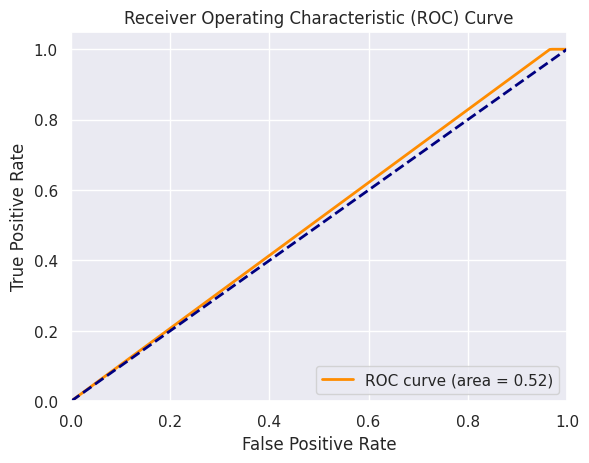

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming logreg_unsampled is your fitted logistic regression model
y_scores = logreg_unsampled.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()



In [42]:
#metrics.plot_roc_curve(logreg_unsampled, X_test, y_test)





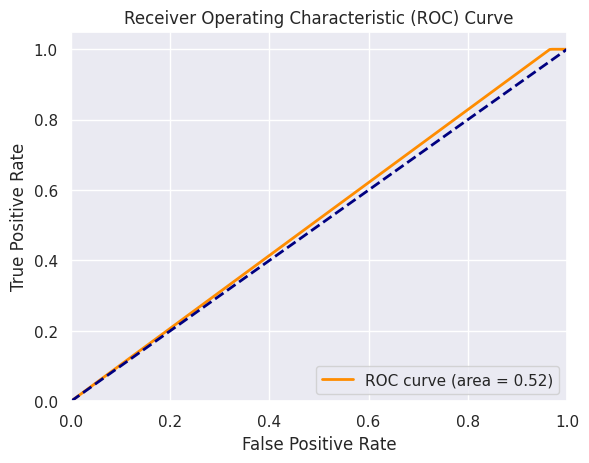

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming logreg_unsampled is your fitted logistic regression model
y_scores = logreg_unsampled.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [44]:
#metrics.plot_roc_curve(logreg_unsampled, X_test, y_test)

> #### Metrics for Logistic Regression - Unsampled:
- Recall on Train: 0.0
- Recall on Test: 0.99
- Area Under the Curve: 0.52

## Let us try out two sampling methods - SMOTE and ADASYN

from imblearn.over_sampling import SMOTE, ADASYN
X_train_smote_lr, y_train_smote_lr = SMOTE().fit_resample(X_train_lr, y_train)
X_train_adasyn_lr, y_train_adasyn_lr = ADASYN().fit_resample(X_train_lr, y_train)

In [45]:
pip install --upgrade imbalanced-learn scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


In [46]:
pip install scikit-learn==0.24.2 imbalanced-learn==0.8.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 21.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [47]:
from imblearn.over_sampling import SMOTE, ADASYN

# Using SMOTE to oversample the minority class
X_train_smote_lr, y_train_smote_lr = SMOTE().fit_resample(X_train_lr, y_train)

# Using ADASYN to oversample the minority class
X_train_adasyn_lr, y_train_adasyn_lr = ADASYN().fit_resample(X_train_lr, y_train)


## 1.2 Logistic Regression with SMOTE

In [48]:
logreg_smote = LogisticRegression().fit(X_train_smote_lr,y_train_smote_lr)

In [49]:
params_lr = {
    'C': np.logspace(-3,3,7),
    'penalty': ['l2']
}

grid_search_2 = GridSearchCV(estimator=logreg_smote,
                    param_grid=params_lr,
                    cv=4,
                    n_jobs=-1, verbose=1,
                    scoring='recall')

In [50]:
%%time
grid_search_2.fit(X_train_smote_lr, y_train_smote_lr)

Fitting 4 folds for each of 7 candidates, totalling 28 fits
CPU times: user 4.78 s, sys: 2.16 s, total: 6.95 s
Wall time: 1min 14s


GridSearchCV(cv=4, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l2']},
             scoring='recall', verbose=1)

In [51]:
grid_search_2.best_score_

0.7800609595792312

In [52]:
def evaluate_model_lr_smote(classifier):
    y_train_pred = classifier.predict(X_train_smote_lr)
    y_test_pred = classifier.predict(X_test)

    print('Train set performance:')
    print(metrics.recall_score(y_train_smote_lr, y_train_pred))
    print(metrics.confusion_matrix(y_train_smote_lr, y_train_pred))
    print("-"*25)
    print('Test set performance:')
    print(metrics.recall_score(y_test, y_test_pred))
    print(metrics.confusion_matrix(y_test, y_test_pred))

In [53]:
lr_smote = grid_search_2.best_estimator_
evaluate_model_lr_smote(lr_smote)

Train set performance:
0.7800619934076413
[[778452 188425]
 [212653 754224]]
-------------------------
Test set performance:
1.0
[[     0 322292]
 [     0   1877]]


#### ROC Curve

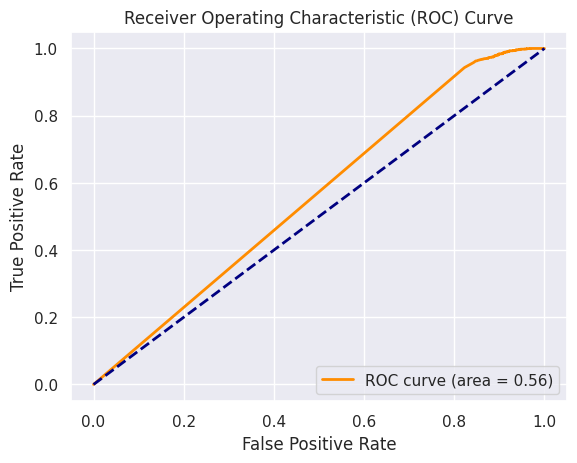

In [54]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming logreg_smote is your logistic regression model
y_scores = logreg_smote.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


> #### Metrics for Logistic Regression - SMOTE:
- Recall on Train: 0.78
- Recall on Test: 1.0
- Area Under the Curve: 0.56

## 1.3 Logistic Regression with ADASYN

In [55]:
logreg_adasyn = LogisticRegression().fit(X_train_adasyn_lr,y_train_adasyn_lr)

In [56]:
params_lr = {
    'C': np.logspace(-3,3,7),
    'penalty': ['l2']
}

grid_search_3 = GridSearchCV(estimator=logreg_adasyn,
                    param_grid=params_lr,
                    cv=4,
                    n_jobs=-1, verbose=1,
                    scoring='recall')

In [57]:
%%time
grid_search_3.fit(X_train_adasyn_lr, y_train_adasyn_lr)

Fitting 4 folds for each of 7 candidates, totalling 28 fits
CPU times: user 3.95 s, sys: 1.47 s, total: 5.42 s
Wall time: 55.9 s


GridSearchCV(cv=4, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l2']},
             scoring='recall', verbose=1)

In [58]:
grid_search_3.best_score_

0.7313620616094583

In [59]:
def evaluate_model_lr_adasyn(classifier):
    y_train_pred = classifier.predict(X_train_adasyn_lr)
    y_test_pred = classifier.predict(X_test)

    print('Train set performance:')
    print(metrics.recall_score(y_train_adasyn_lr, y_train_pred))
    print(metrics.confusion_matrix(y_train_adasyn_lr, y_train_pred))
    print("-"*25)
    print('Test set performance:')
    print(metrics.recall_score(y_test, y_test_pred))
    print(metrics.confusion_matrix(y_test, y_test_pred))

In [60]:
lr_adasyn = grid_search_3.best_estimator_
evaluate_model_lr_adasyn(lr_adasyn)

Train set performance:
0.7314324142568931
[[724858 242019]
 [259584 706966]]
-------------------------
Test set performance:
1.0
[[     5 322287]
 [     0   1877]]


#### ROC Curve

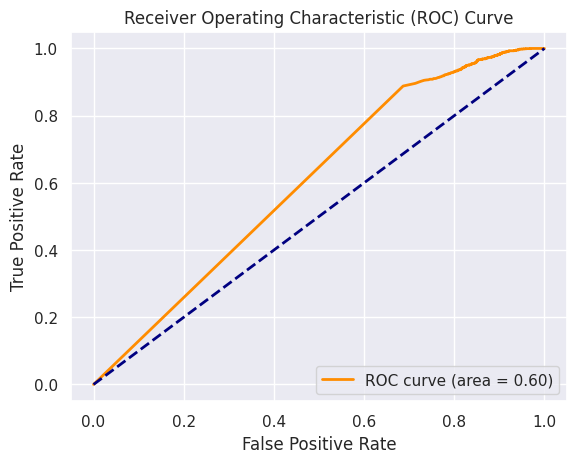

In [61]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming logreg_adasyn is your logistic regression model
y_scores = logreg_adasyn.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


> #### Metrics for Logistic Regression - ADASYN:
- Recall on Train: 0.73
- Recall on Test: 1.0
- Area Under the Curve: 0.60

-----------------------------

# 2.1 Decision Tree Classifier - Unsampled

In [62]:
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image
from six import StringIO
from sklearn.tree import export_graphviz
import pydotplus, graphviz
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score

### Creating Helper Functions

In [63]:
def get_graph(classifier):
    dot_data = StringIO()

    export_graphviz(classifier, out_file = dot_data, filled = True, rounded = True,
               feature_names=X.columns,
               class_names=['No Fraud', 'Fraud'])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph

In [64]:
def evaluate_model_unsampled(classifier):
    y_train_pred = classifier.predict(X_train)
    y_test_pred = classifier.predict(X_test)

    print('Train set performance:')
    print(recall_score(y_train, y_train_pred))
    print(confusion_matrix(y_train, y_train_pred))
    print("-"*25)
    print('Test set performance:')
    print(recall_score(y_test, y_test_pred))
    print(confusion_matrix(y_test, y_test_pred))

### Hyper-parameter tuning using Grid Search CV

In [65]:
dt_unsampled = DecisionTreeClassifier(random_state=42).fit(X_train,y_train)

#### After various trial and error methods, fixing hyper-parameters to:

In [66]:
params = {
    'max_depth': [7],
    'min_samples_leaf': [80,110],
    'criterion': ['gini']
}

grid_search_4 = GridSearchCV(estimator=dt_unsampled,
                    param_grid=params,
                    cv=5,
                    n_jobs=-1, verbose=1,
                    scoring='recall')

In [67]:
%%time
grid_search_4.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: user 4.14 s, sys: 116 ms, total: 4.26 s
Wall time: 31 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [7],
                         'min_samples_leaf': [80, 110]},
             scoring='recall', verbose=1)

In [68]:
grid_search_4.best_score_

0.33167744227353463

In [69]:
dt_best = grid_search_4.best_estimator_
evaluate_model_unsampled(dt_best)

Train set performance:
0.30982412506661927
[[966063    814]
 [  3885   1744]]
-------------------------
Test set performance:
0.2855620671283964
[[321988    304]
 [  1341    536]]


In [70]:
grid_search_4.best_params_

{'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 80}

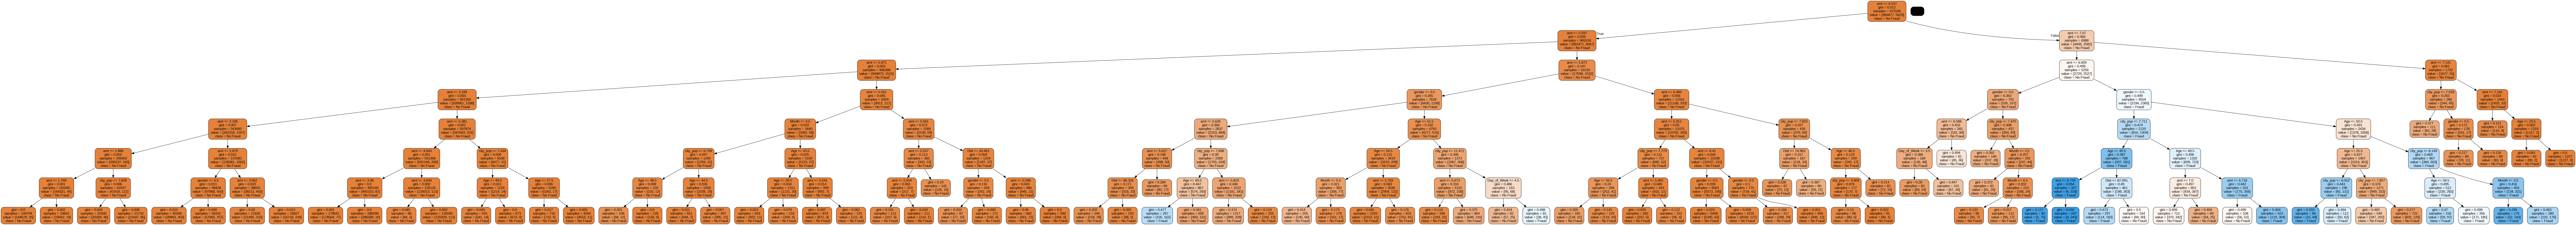

In [71]:
gph = get_graph(dt_best)
Image(gph.create_png())

#### ROC Curve

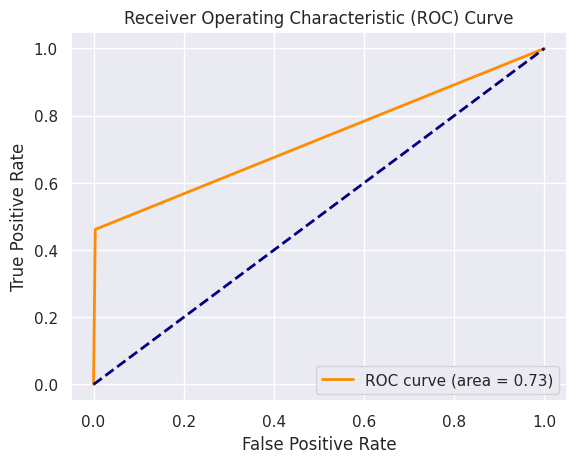

In [72]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming dt_unsampled is your decision tree model
y_scores = dt_unsampled.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


> #### Metrics for Decision Trees - Unsampled:
- Recall on Train: 0.30
- Recall on Test: 0.28
- Area Under the Curve: 0.73

## 2.2 Decision Tree with SMOTE

In [73]:
X_train_smote, y_train_smote = SMOTE().fit_resample(X_train, y_train)

In [74]:
dt_smote = DecisionTreeClassifier(random_state=42).fit(X_train_smote,y_train_smote)

### Creating Helper Functions

In [75]:
def evaluate_model_smote(classifier):
    y_train_pred = classifier.predict(X_train_smote)
    y_test_pred = classifier.predict(X_test)

    print('Train set performance:')
    print(recall_score(y_train_smote, y_train_pred))
    print(confusion_matrix(y_train_smote, y_train_pred))
    print("-"*25)
    print('Test set performance:')
    print(recall_score(y_test, y_test_pred))
    print(confusion_matrix(y_test, y_test_pred))

In [76]:
params = {
    'max_depth': [7],
    'min_samples_leaf': [80,110],
    'criterion': ['gini']
}

grid_search_5 = GridSearchCV(estimator=dt_smote,
                    param_grid=params,
                    cv=5,
                    n_jobs=-1, verbose=1,
                    scoring='recall')

In [77]:
%%time
grid_search_5.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: user 10.1 s, sys: 189 ms, total: 10.3 s
Wall time: 1min 18s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [7],
                         'min_samples_leaf': [80, 110]},
             scoring='recall', verbose=1)

In [78]:
grid_search_5.best_score_

0.8333138397293005

In [79]:
dt_smote = grid_search_5.best_estimator_
evaluate_model_smote(dt_smote)

Train set performance:
0.8291271795688593
[[897071  69806]
 [165213 801664]]
-------------------------
Test set performance:
0.7991475759190197
[[299115  23177]
 [   377   1500]]


In [80]:
grid_search_5.best_params_

{'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 80}

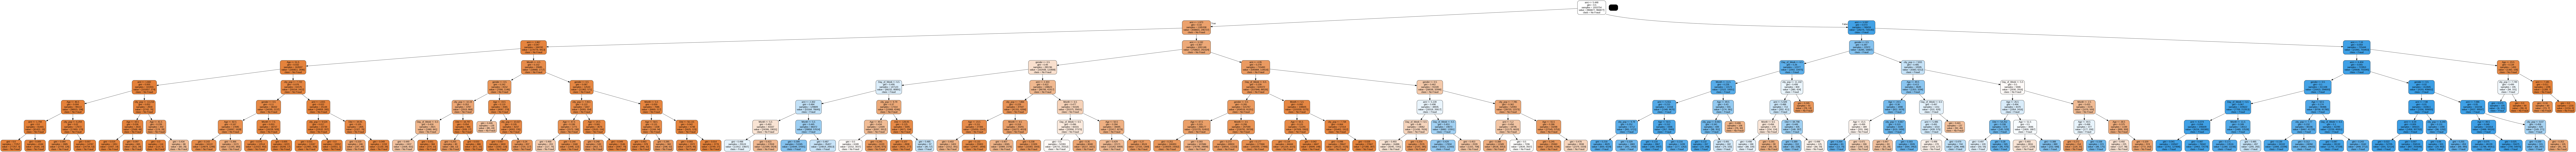

In [81]:
gph = get_graph(dt_smote)
Image(gph.create_png())

#### ROC Curve

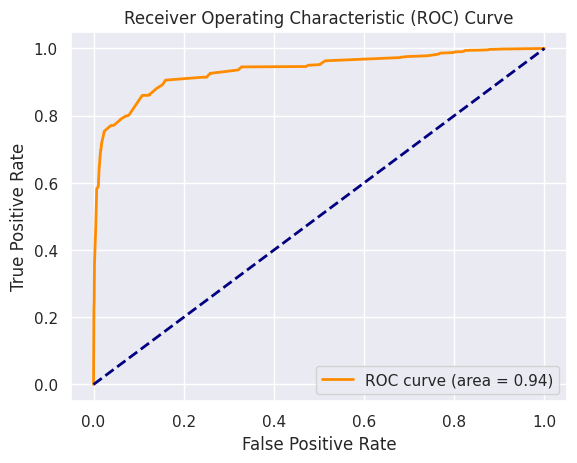

In [82]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming dt_smote is your decision tree model
y_scores = dt_smote.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


> #### Metrics for Decision Trees - SMOTE:
- Recall on Train: 0.85
- Recall on Test: 0.84
- Area Under the Curve: 0.94

## 2.3 Decision Tree with ADASYN

In [83]:
X_train_adasyn, y_train_adasyn = ADASYN().fit_resample(X_train, y_train)

### Creating Helper Functions

In [84]:
def evaluate_model_adasyn(classifier):
    y_train_pred = classifier.predict(X_train_adasyn)
    y_test_pred = classifier.predict(X_test)

    print('Train set performance:')
    print(recall_score(y_train_adasyn, y_train_pred))
    print(confusion_matrix(y_train_adasyn, y_train_pred))
    print("-"*25)
    print('Test set performance:')
    print(recall_score(y_test, y_test_pred))
    print(confusion_matrix(y_test, y_test_pred))

In [85]:
dt_adasyn = DecisionTreeClassifier(random_state=42).fit(X_train_adasyn,y_train_adasyn)

In [86]:
params = {
    'max_depth': [7],
    'min_samples_leaf': [80,110],
    'criterion': ['gini']
}

grid_search_6 = GridSearchCV(estimator=dt_adasyn,
                    param_grid=params,
                    cv=5,
                    n_jobs=-1, verbose=1,
                    scoring='recall')

In [87]:
%%time
grid_search_6.fit(X_train_adasyn, y_train_adasyn)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: user 10.8 s, sys: 191 ms, total: 11 s
Wall time: 1min 13s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [7],
                         'min_samples_leaf': [80, 110]},
             scoring='recall', verbose=1)

In [88]:
grid_search_6.best_score_

0.8364098528180431

In [89]:
dt_adasyn = grid_search_6.best_estimator_
evaluate_model_adasyn(dt_adasyn)

Train set performance:
0.8461928897352916
[[871233  95644]
 [149090 820241]]
-------------------------
Test set performance:
0.851891315929675
[[290408  31884]
 [   278   1599]]


In [90]:
grid_search_6.best_params_

{'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 80}

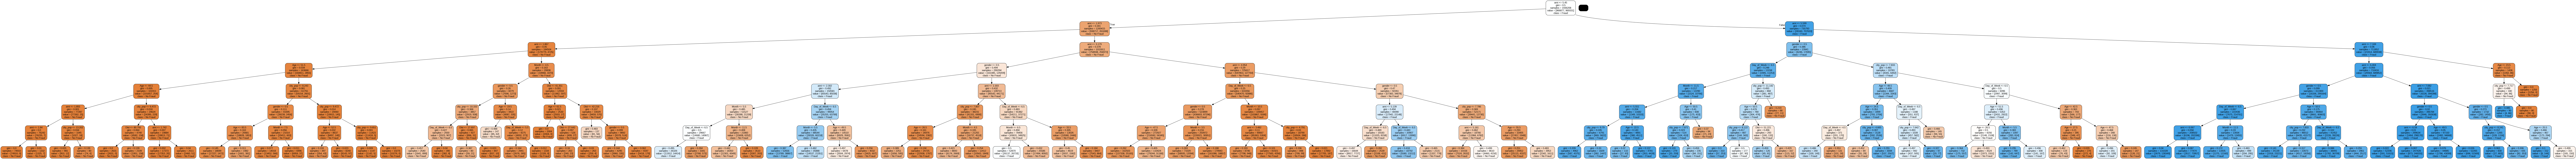

In [91]:
gph = get_graph(dt_adasyn)
Image(gph.create_png())

#### ROC Curve

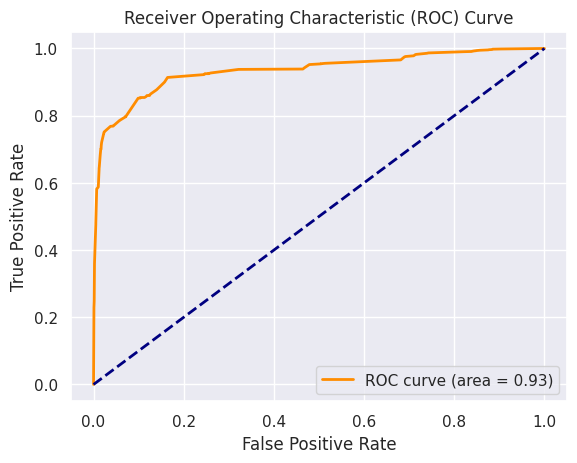

In [92]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming dt_adasyn is your decision tree model
y_scores = dt_adasyn.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


> #### Metrics for Decision Trees - ADASYN:
- Recall on Train: 0.84
- Recall on Test: 0.85
- Area Under the Curve: 0.94

---------------

# 3.1 Random Forest - Unsampled

In [93]:
from sklearn.ensemble import RandomForestClassifier

In [94]:
rf_unsampled = RandomForestClassifier(random_state=42).fit(X_train, y_train)

#### After various trial and error methods, fixing hyper-parameters to:

In [95]:
# Applying same parameters as the ones finalised in Decision Trees and building up on the n_estimators:


params = {
    'max_depth': [7],
    'min_samples_leaf': [80,110],
    'criterion': ['gini'],
    'n_estimators': [10,15,30]
}

grid_search_7 = GridSearchCV(estimator=rf_unsampled,
                    param_grid=params,
                    cv=5,
                    n_jobs=-1, verbose=1,
                    scoring='recall')

In [96]:
%%time
grid_search_7.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
CPU times: user 15.7 s, sys: 652 ms, total: 16.3 s
Wall time: 6min 20s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [7],
                         'min_samples_leaf': [80, 110],
                         'n_estimators': [10, 15, 30]},
             scoring='recall', verbose=1)

In [97]:
rf_best = grid_search_7.best_estimator_
evaluate_model_unsampled(rf_best)

Train set performance:
0.12826434535441464
[[966752    125]
 [  4907    722]]
-------------------------
Test set performance:
0.11401172083111348
[[322246     46]
 [  1663    214]]


In [98]:
grid_search_7.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'min_samples_leaf': 110,
 'n_estimators': 15}

#### ROC Curve

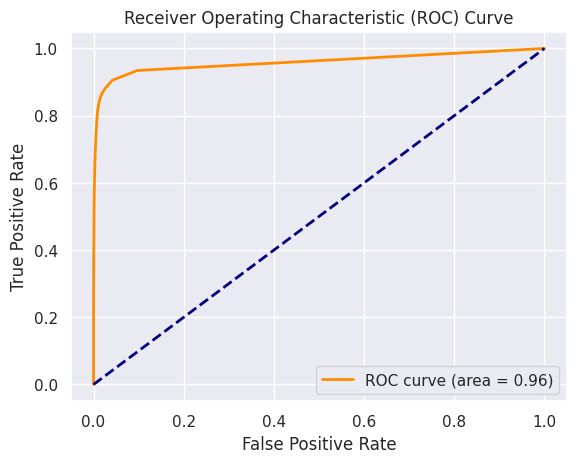

In [99]:
#metrics.plot_roc_curve(rf_unsampled, X_test, y_test)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming rf_unsampled is your random forest model
y_scores = rf_unsampled.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


> #### Metrics for Random Forest - Unsampled:
- Recall on Train: 0.12
- Recall on Test: 0.11
- Area Under the Curve: 0.96

# 3.2 Random Forest - SMOTE

In [100]:
rf_smote = RandomForestClassifier(random_state=42).fit(X_train_smote, y_train_smote)

In [101]:
params = {
    'max_depth': [7],
    'min_samples_leaf': [80,110],
    'criterion': ['gini'],
    'n_estimators': [10,15,30]
}

grid_search_8 = GridSearchCV(estimator=rf_smote,
                    param_grid=params,
                    cv=5,
                    n_jobs=-1, verbose=1,
                    scoring='recall')

In [102]:
%%time
grid_search_8.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
CPU times: user 29.6 s, sys: 1.35 s, total: 30.9 s
Wall time: 16min 13s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [7],
                         'min_samples_leaf': [80, 110],
                         'n_estimators': [10, 15, 30]},
             scoring='recall', verbose=1)

In [103]:
rf_smote = grid_search_8.best_estimator_
evaluate_model_smote(rf_smote)

Train set performance:
0.7890941660624878
[[932103  34774]
 [203920 762957]]
-------------------------
Test set performance:
0.7693127330847096
[[310702  11590]
 [   433   1444]]


In [104]:
grid_search_8.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'min_samples_leaf': 80,
 'n_estimators': 10}

#### ROC Curve

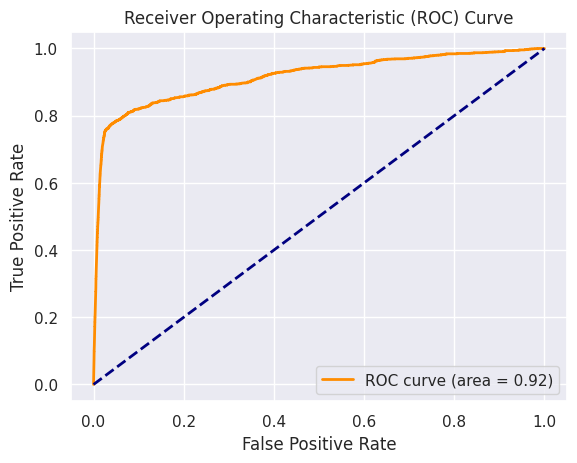

In [105]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming rf_smote is your random forest model
y_scores = rf_smote.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


> #### Metrics for Random Forest - SMOTE:
- Recall on Train: 0.79
- Recall on Test: 0.77
- Area Under the Curve: 0.91

# 3.3 Random Forest - ADASYN

In [106]:
rf_adasyn = RandomForestClassifier(random_state=42).fit(X_train_adasyn, y_train_adasyn)

In [107]:
# Applying same parameters as the ones finalised in Decision Trees and building up on the n_estimators:

params = {
    'max_depth': [7],
    'min_samples_leaf': [80,110],
    'criterion': ['gini'],
    'n_estimators': [10,15,30]
}

grid_search_9 = GridSearchCV(estimator=rf_adasyn,
                    param_grid=params,
                    cv=5,
                    n_jobs=-1, verbose=1,
                    scoring='recall')

In [108]:
%%time
grid_search_9.fit(X_train_adasyn, y_train_adasyn)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
CPU times: user 29.7 s, sys: 1.08 s, total: 30.8 s
Wall time: 15min 3s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [7],
                         'min_samples_leaf': [80, 110],
                         'n_estimators': [10, 15, 30]},
             scoring='recall', verbose=1)

In [109]:
grid_search_9.best_score_

0.7755121729609172

In [110]:
rf_adasyn = grid_search_9.best_estimator_
evaluate_model_adasyn(rf_adasyn)

Train set performance:
0.78032684397796
[[929668  37209]
 [212936 756395]]
-------------------------
Test set performance:
0.7741076185402238
[[309922  12370]
 [   424   1453]]


In [111]:
grid_search_9.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'min_samples_leaf': 110,
 'n_estimators': 10}

#### ROC Curve

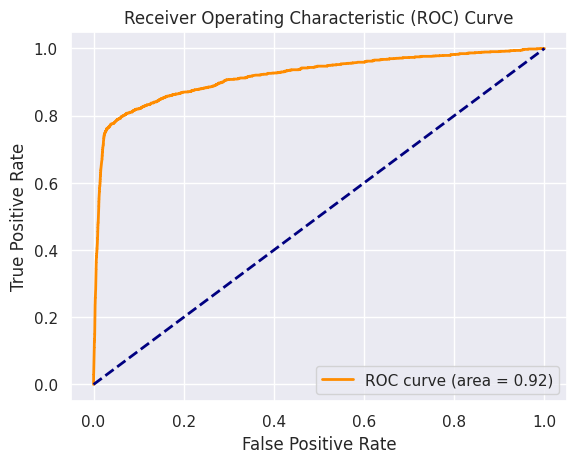

In [112]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming rf_adasyn is your random forest model
y_scores = rf_adasyn.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


> #### Metrics for Random Forest - ADASYN:
- Recall on Train: 0.78
- Recall on Test: 0.77
- Area Under the Curve: 0.92

-----

# 4.1 XGBoost - Unsampled

In [113]:
from xgboost import XGBClassifier

In [114]:
xgb_unsampled = XGBClassifier().fit(X_train, y_train)

In [115]:
# Applying same parameters as the ones finalised in Decision Trees and building up on the learning_rate:

params = {
    'max_depth': [7],
    'min_samples_leaf': [80],
    'criterion': ['gini'],
    'n_estimators': [15],
    'learning_rate': [0.1,0.3,0.5]
}

grid_search_10 = GridSearchCV(estimator=xgb_unsampled,
                    param_grid=params,
                    cv=5,
                    n_jobs=-1, verbose=1,
                    scoring='recall')

In [116]:
%%time
grid_search_10.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
CPU times: user 3.52 s, sys: 135 ms, total: 3.66 s
Wall time: 26 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'criterion': ['gini'],
                         'learning_rate': [0.1, 0.3, 0.5], 'max_depth': [7],
                         'min_samples_leaf': [80], 'n_estimators': [15]},
             scoring='recall', verbose=1)

In [117]:
xgb_best_unsampled = grid_search_10.best_estimator_
evaluate_model_unsampled(xgb_best_unsampled)

Train set performance:
0.3574347130929117
[[966420    457]
 [  3617   2012]]
-------------------------
Test set performance:
0.31166755460841766
[[322050    242]
 [  1292    585]]


In [118]:
grid_search_10.best_params_

{'criterion': 'gini',
 'learning_rate': 0.5,
 'max_depth': 7,
 'min_samples_leaf': 80,
 'n_estimators': 15}

#### ROC Curve

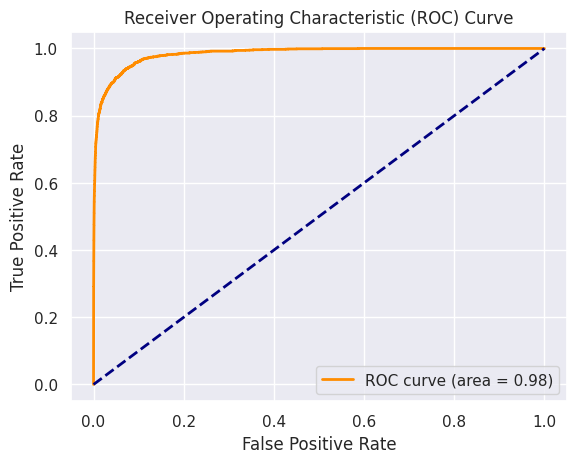

In [119]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming xgb_unsampled is your XGBoost model
y_scores = xgb_unsampled.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


> #### Metrics for XGBoost - Unsampled:
- Recall on Train: 0.41
- Recall on Test: 0.36
- Area Under the Curve: 0.98

# 4.2 XGBoost - SMOTE

In [120]:
xgb_smote = XGBClassifier().fit(X_train_smote, y_train_smote)

In [121]:
# Applying same parameters as the ones finalised in Decision Trees and building up on the learning_rate:

params = {
    'max_depth': [7],
    'min_samples_leaf': [80],
    'criterion': ['gini'],
    'n_estimators': [15],
    'learning_rate': [0.1,0.3,0.5]
}

grid_search_11 = GridSearchCV(estimator=xgb_smote,
                    param_grid=params,
                    cv=5,
                    n_jobs=-1, verbose=1,
                    scoring='recall')

In [122]:
%%time
grid_search_11.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
CPU times: user 7.89 s, sys: 175 ms, total: 8.06 s
Wall time: 1min 2s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'criterion': ['gini'],
                         'learning_rate': [0.1, 0.3, 0.5], 'max_depth': [7],
                         'min_samples_leaf': [80], 'n_estimators': [15]},
             scoring='recall', verbose=1)

In [123]:
xgb_best_smote = grid_search_11.best_estimator_
evaluate_model_smote(xgb_best_smote)

Train set performance:
0.8776297295312641
[[911325  55552]
 [118317 848560]]
-------------------------
Test set performance:
0.8119339371337241
[[303575  18717]
 [   353   1524]]


In [124]:
grid_search_11.best_params_

{'criterion': 'gini',
 'learning_rate': 0.5,
 'max_depth': 7,
 'min_samples_leaf': 80,
 'n_estimators': 15}

#### ROC Curve

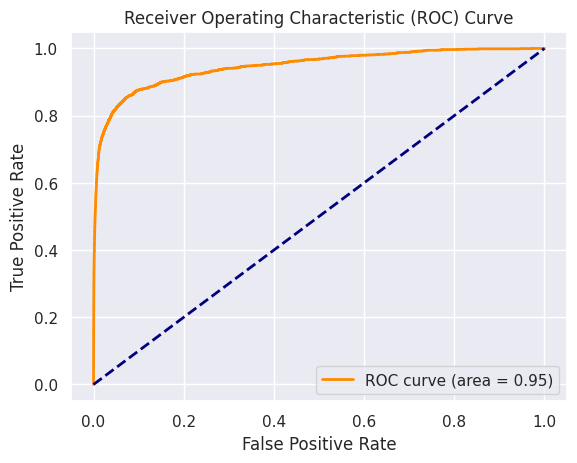

In [125]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming xgb_smote is your XGBoost model
y_scores = xgb_smote.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


> #### Metrics for XGBoost - SMOTE:
- Recall on Train: 0.87
- Recall on Test: 0.81
- Area Under the Curve: 0.95

# 4.3 XGBoost - ADASYN

In [126]:
xgb_adasyn = XGBClassifier().fit(X_train_adasyn, y_train_adasyn)

In [127]:
# Applying same parameters as the ones finalised in Decision Trees and building up on the learning_rate:

params = {
    'max_depth': [7],
    'min_samples_leaf': [80],
    'criterion': ['gini'],
    'n_estimators': [15],
    'learning_rate': [0.1,0.3,0.5]
}
grid_search_12 = GridSearchCV(estimator=xgb_adasyn,
                    param_grid=params,
                    cv=5,
                    n_jobs=-1, verbose=1,
                    scoring='recall')

In [128]:
%%time
grid_search_12.fit(X_train_adasyn, y_train_adasyn)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
CPU times: user 6.72 s, sys: 159 ms, total: 6.88 s
Wall time: 55.9 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'criterion': ['gini'],
                         'learning_rate': [0.1, 0.3, 0.5], 'max_depth': [7],
                         'min_samples_leaf': [80], 'n_estimators': [15]},
             scoring='recall', verbose=1)

In [129]:
xgb_best_adasyn = grid_search_12.best_estimator_
evaluate_model_adasyn(xgb_best_adasyn)

Train set performance:
0.8703002379991974
[[906233  60644]
 [125722 843609]]
-------------------------
Test set performance:
0.8140649973361748
[[301795  20497]
 [   349   1528]]


In [130]:
type(xgb_best_adasyn)

xgboost.sklearn.XGBClassifier

In [131]:
grid_search_12.best_params_

{'criterion': 'gini',
 'learning_rate': 0.5,
 'max_depth': 7,
 'min_samples_leaf': 80,
 'n_estimators': 15}

#### ROC Curve

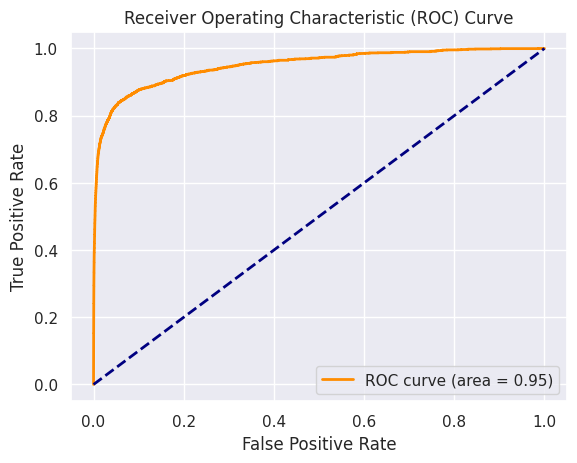

In [132]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming xgb_adasyn is your XGBoost model
y_scores = xgb_adasyn.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


> #### Metrics for Random Forest - SMOTE:
- Recall on Train: 0.86
- Recall on Test: 0.81
- Area Under the Curve: 0.95

# `Testing the results on the unseen Test Data:`

In [133]:
# Reading the test dataset

from google.colab import drive

drive.mount('/content/gdrive')

df_test= pd.read_csv('/content/gdrive/MyDrive/Python projects/fraudTest.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [134]:
# Considering only the relevant columns/features in a new dataframe

fraudTest = df_test[['trans_date_trans_time','amt','gender','lat','long','city_pop','dob','merch_lat','merch_long','is_fraud']]
fraudTest.head()

trans_date_trans_time    amt gender      lat      long  city_pop  \
0   2020-06-21 12:14:25   2.86      M  33.9659  -80.9355    333497   
1   2020-06-21 12:14:33  29.84      F  40.3207 -110.4360       302   
2   2020-06-21 12:14:53  41.28      F  40.6729  -73.5365     34496   
3   2020-06-21 12:15:15  60.05      M  28.5697  -80.8191     54767   
4   2020-06-21 12:15:17   3.19      M  44.2529  -85.0170      1126   

          dob  merch_lat  merch_long  is_fraud  
0  1968-03-19  33.986391  -81.200714         0  
1  1990-01-17  39.450498 -109.960431         0  
2  1970-10-21  40.495810  -74.196111         0  
3  1987-07-25  28.812398  -80.883061         0  
4  1955-07-06  44.959148  -85.884734         0

In [135]:
fraudTrain.head()

amt  gender  city_pop  Age  Day_of_Week  Month        Dist
0  1.603420       1  8.159089   31            2      1   10.509708
1  4.674976       1  5.003946   41            2      1   30.171468
2  5.394127       0  8.331827   57            2      1  107.746268
3  3.806662       0  7.569928   52            2      1   97.629363
4  3.736717       0  4.595120   33            2      1   66.236025

In [136]:
# Converting columns to datetime for fraudTest

fraudTest.dob = pd.to_datetime(fraudTest['dob'])
fraudTest.trans_date_trans_time = pd.to_datetime(fraudTest['trans_date_trans_time'])

In [137]:
# Creating a new column called Transaction date and converting into datetime

fraudTest['Transaction_Date'] = pd.to_datetime(fraudTest['trans_date_trans_time'], format='%Y:%M:%D').dt.date
fraudTest.Transaction_Date = pd.to_datetime(fraudTest['Transaction_Date'])

In [138]:
# Creating a new column called Transaction Time

fraudTest['Transaction_Time'] = pd.to_datetime(fraudTest['trans_date_trans_time'], format='%Y:%M:%D').dt.time

In [139]:
# Creating a new column called Age

fraudTest['Age'] = round((fraudTest['Transaction_Date'] - fraudTest['dob'])/np.timedelta64(1, 'Y'))
fraudTest.Age = fraudTest.Age.astype('int')

In [140]:
fraudTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   trans_date_trans_time  555719 non-null  datetime64[ns]
 1   amt                    555719 non-null  float64       
 2   gender                 555719 non-null  object        
 3   lat                    555719 non-null  float64       
 4   long                   555719 non-null  float64       
 5   city_pop               555719 non-null  int64         
 6   dob                    555719 non-null  datetime64[ns]
 7   merch_lat              555719 non-null  float64       
 8   merch_long             555719 non-null  float64       
 9   is_fraud               555719 non-null  int64         
 10  Transaction_Date       555719 non-null  datetime64[ns]
 11  Transaction_Time       555719 non-null  object        
 12  Age                    555719 non-null  int6

In [141]:
# Calling the function created earlier to calculate the Day of the Week

fraudTest['Day_of_Week'] = fraudTest['Transaction_Date'].apply(DoW)

In [142]:
# Creating a new column Month

fraudTest['Month'] = pd.DatetimeIndex(fraudTest.trans_date_trans_time).month

# Making Gender column binary

fraudTest['gender'] = fraudTest['gender'].map({'F':1, 'M':0})

# Ensuring Day of Week is represented numerically
fraudTest['Day_of_Week'] = fraudTest['Day_of_Week'].map({'Monday':1, 'Tuesday':2, 'Wednesday': 3, 'Thursday': 4,
                                                          'Friday':5, 'Saturday':6, 'Sunday': 7})

In [143]:
# Calling the function created earlier to calculate the Distance between the customer's home location and
# the location of transactions (fraudulent or otherwise)

Dist2 = []
for a,b,c,d in zip(fraudTest['lat'], fraudTest['long'], fraudTest['merch_lat'], fraudTest['merch_long']):
    Dist2.append(haversineDistance(a,b,c,d))

In [144]:
# Adding the calculated Distance column in the test dataframe

fraudTest['Dist'] = Dist2
fraudTest.head()

trans_date_trans_time    amt  gender      lat      long  city_pop  \
0   2020-06-21 12:14:25   2.86       0  33.9659  -80.9355    333497   
1   2020-06-21 12:14:33  29.84       1  40.3207 -110.4360       302   
2   2020-06-21 12:14:53  41.28       1  40.6729  -73.5365     34496   
3   2020-06-21 12:15:15  60.05       0  28.5697  -80.8191     54767   
4   2020-06-21 12:15:17   3.19       0  44.2529  -85.0170      1126   

         dob  merch_lat  merch_long  is_fraud Transaction_Date  \
0 1968-03-19  33.986391  -81.200714         0       2020-06-21   
1 1990-01-17  39.450498 -109.960431         0       2020-06-21   
2 1970-10-21  40.495810  -74.196111         0       2020-06-21   
3 1987-07-25  28.812398  -80.883061         0       2020-06-21   
4 1955-07-06  44.959148  -85.884734         0       2020-06-21   

  Transaction_Time  Age  Day_of_Week  Month        Dist  
0         12:14:25   52            7      6   24.748687  
1         12:14:33   30            7      6   98.988771  
2         12:14:53   50            7      6   73.344386  
3         12:15:15   33            7      6   27.746011  
4         12:15:17   65            7      6  105.772207

In [145]:
# Dropping unnecessary columns

fraudTest.drop(['trans_date_trans_time','Transaction_Date','Transaction_Time','dob',
                 'lat','long', 'merch_lat','merch_long'], axis=1, inplace=True)
fraudTest.head()

amt  gender  city_pop  is_fraud  Age  Day_of_Week  Month        Dist
0   2.86       0    333497         0   52            7      6   24.748687
1  29.84       1       302         0   30            7      6   98.988771
2  41.28       1     34496         0   50            7      6   73.344386
3  60.05       0     54767         0   33            7      6   27.746011
4   3.19       0      1126         0   65            7      6  105.772207

## `Model Selection and Model Building`
> Based on the Recall scores, AUC Scores, and Confusion Matrices collected from the 12 algorithms (4 algorithms - unsampled and sampled), following is the summary of all values to help us pick the best model of all:

In [146]:
summary_dict = {
    'Model': ['Logistic Regression - Unsampled', 'Logistic Regression - SMOTE', 'Logistic Regression - ADASYN',
             'Decision Trees - Unsampled', 'Decision Trees - SMOTE', 'Decision Trees - ADASYN',
             'Random Forest - Unsampled', 'Random Forest - SMOTE', 'Random Forest - ADASYN',
             'XGBoost - Unsampled', 'XGBoost - SMOTE', 'XGBoost - ADASYN'],
    'Recall on Train' : [0.0,0.78,0.73,0.30,0.85,0.84,0.12,0.79,0.78,0.41,0.87,0.86],
    'Recall on Test' : [0.99,1.0,1.0,0.28,0.84,0.85,0.11,0.77,0.77,0.36,0.81,0.81],
    'AUC Score' : [0.52,0.56,0.60,0.73,0.94,0.93,0.96,0.91,0.92,0.98,0.95,0.95]
}

summary_df = pd.DataFrame(summary_dict)
summary_df

Model  Recall on Train  Recall on Test  \
0   Logistic Regression - Unsampled             0.00            0.99   
1       Logistic Regression - SMOTE             0.78            1.00   
2      Logistic Regression - ADASYN             0.73            1.00   
3        Decision Trees - Unsampled             0.30            0.28   
4            Decision Trees - SMOTE             0.85            0.84   
5           Decision Trees - ADASYN             0.84            0.85   
6         Random Forest - Unsampled             0.12            0.11   
7             Random Forest - SMOTE             0.79            0.77   
8            Random Forest - ADASYN             0.78            0.77   
9               XGBoost - Unsampled             0.41            0.36   
10                  XGBoost - SMOTE             0.87            0.81   
11                 XGBoost - ADASYN             0.86            0.81   

    AUC Score  
0        0.52  
1        0.56  
2        0.60  
3        0.73  
4        0.94  
5        0.93  
6        0.96  
7        0.91  
8        0.92  
9        0.98  
10       0.95  
11       0.95

In [147]:
summary_df.sort_values('AUC Score', ascending = False)

Model  Recall on Train  Recall on Test  \
9               XGBoost - Unsampled             0.41            0.36   
6         Random Forest - Unsampled             0.12            0.11   
10                  XGBoost - SMOTE             0.87            0.81   
11                 XGBoost - ADASYN             0.86            0.81   
4            Decision Trees - SMOTE             0.85            0.84   
5           Decision Trees - ADASYN             0.84            0.85   
8            Random Forest - ADASYN             0.78            0.77   
7             Random Forest - SMOTE             0.79            0.77   
3        Decision Trees - Unsampled             0.30            0.28   
2      Logistic Regression - ADASYN             0.73            1.00   
1       Logistic Regression - SMOTE             0.78            1.00   
0   Logistic Regression - Unsampled             0.00            0.99   

    AUC Score  
9        0.98  
6        0.96  
10       0.95  
11       0.95  
4        0.94  
5        0.93  
8        0.92  
7        0.91  
3        0.73  
2        0.60  
1        0.56  
0        0.52

#### - Following image shows the best scored models from the analysis based on AUC Score, Recall on Train and on Test dataset

In [148]:
# Splitting the test data into X and y:

y_final = fraudTest.pop('is_fraud')
X_final = fraudTest

In [149]:
X_final_adasyn, y_final_adasyn = ADASYN().fit_resample(X_final, y_final)
xgb_final_adasyn = XGBClassifier(random_state=42, criterion='gini', max_depth=7, min_samples_leaf=80, learning_rate=0.5, n_estimators=15).fit(X_final_adasyn, y_final_adasyn)
y_pred_final = xgb_final_adasyn.predict(X_final_adasyn)

In [150]:
pred = xgb_best_adasyn.predict(X_train_adasyn)

In [151]:
print(len(y_final_adasyn), len(pred))

1107022 1936208


In [154]:
threshold = 0.5

binary_pred = (pred[:len(y_final_adasyn)] > threshold)


print("Length of y_final_adasyn:", len(y_final_adasyn))
print("Length of binary_pred:", len(binary_pred))

# Calculate and print recall and confusion matrix
print("Recall:", recall_score(y_final_adasyn, binary_pred))
print("Confusion Matrix:\n", confusion_matrix(y_final_adasyn, binary_pred))


Length of y_final_adasyn: 1107022
Length of binary_pred: 1107022
Recall: 0.2604562668940894
Confusion Matrix:
 [[516386  37188]
 [409299 144149]]


### Testing the unseen data by using XGBoost - ADASYN Modelled Predictors:

In [156]:
print(recall_score(y_final_adasyn, y_pred_final))
print(confusion_matrix(y_final_adasyn, y_pred_final))

0.9494333704340787
[[521350  32224]
 [ 27986 525462]]


### Let's check the Recall Score and Confusion Matrix on the final test data

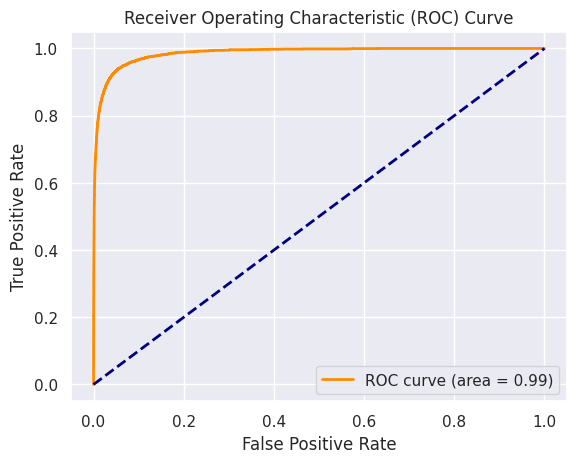

In [157]:
y_scores = xgb_final_adasyn.predict_proba(X_final)[:, 1]
fpr, tpr, thresholds = roc_curve(y_final, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

> ## XGBoost - ADASYN model has 94.8% or approx 95% Sensitivity towards predicting Fraudulent Transactions

In [158]:
cnf = confusion_matrix(y_final_adasyn, y_pred_final)
cnf

array([[521350,  32224],
       [ 27986, 525462]])

> # `Cost Benefit Analysis`
- The Cost Benefit Analysis is to be done on the original data
- Merging the train and test data to make an original dataframe

In [159]:
fraud = pd.concat([df, df_test], axis=0)
fraud.head()

Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2                fraud_Lind-Buckridge  entertainment  220.11     Edward   
3  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00     Jeremy   
4                 fraud_Keeling-Crist       misc_pos   41.96      Tyler   

      last gender                        street  ...      lat      long  \
0    Banks      F                561 Perry Cove  ...  36.0788  -81.1781   
1     Gill      F  43039 Riley Greens Suite 393  ...  48.8878 -118.2105   
2  Sanchez      M      594 White Dale Suite 530  ...  42.1808 -112.2620   
3    White      M   9443 Cynthia Court Apt. 038  ...  46.2306 -112.1138   
4   Garcia      M              408 Bradley Rest  ...  38.4207  -79.4629   

   city_pop                                job         dob  \
0      3495          Psychologist, counselling  1988-03-09   
1       149  Special educational needs teacher  1978-06-21   
2      4154        Nature conservation officer  1962-01-19   
3      1939                    Patent attorney  1967-01-12   
4        99     Dance movement psychotherapist  1986-03-28   

                          trans_num   unix_time  merch_lat  merch_long  \
0  0b242abb623afc578575680df30655b9  1325376018  36.011293  -82.048315   
1  1f76529f8574734946361c461b024d99  1325376044  49.159047 -118.186462   
2  a1a22d70485983eac12b5b88dad1cf95  1325376051  43.150704 -112.154481   
3  6b849c168bdad6f867558c3793159a81  1325376076  47.034331 -112.561071   
4  a41d7549acf90789359a9aa5346dcb46  1325376186  38.674999  -78.632459   

   is_fraud  
0         0  
1         0  
2         0  
3         0  
4         0  

[5 rows x 23 columns]

#### Let us take a look at what we need to do in order to perform the cost-benefit analysis step by step:
- ### Part I: Analyse the dataset and find the following figures:

> 1. Average number of transactions per month
> 2. Average number of fraudulent transactions per month
> 3. Average amount per fraudulent transaction

In [160]:
# Since the given (original) dataset is from Jan 1 2019 to Dec 31 2020, the data is of 24 months
# Total transactions can be found by checking the shape of the original dataframe
# Avg transactions per month would be to divide that shape/total by 24 (months)

avg_transactions_pm = fraud.shape[0]//24

In [161]:
print("1. Average number of transactions per month are:", avg_transactions_pm)

1. Average number of transactions per month are: 77183


In [162]:
# Checking only for fraudulent transactions:

fraud[fraud.is_fraud == 1].head()

Unnamed: 0 trans_date_trans_time           cc_num  \
2449        2449   2019-01-02 01:06:37    4613314721966   
2472        2472   2019-01-02 01:47:29  340187018810220   
2523        2523   2019-01-02 03:05:23  340187018810220   
2546        2546   2019-01-02 03:38:03    4613314721966   
2553        2553   2019-01-02 03:55:47  340187018810220   

                              merchant       category     amt  first    last  \
2449            fraud_Rutherford-Mertz    grocery_pos  281.06  Jason  Murphy   
2472  fraud_Jenkins, Hauck and Friesen  gas_transport   11.52  Misty    Hart   
2523            fraud_Goodwin-Nitzsche    grocery_pos  276.31  Misty    Hart   
2546            fraud_Erdman-Kertzmann  gas_transport    7.03  Jason  Murphy   
2553                fraud_Koepp-Parker    grocery_pos  275.73  Misty    Hart   

     gender                     street  ...      lat     long  city_pop  \
2449      M  542 Steve Curve Suite 011  ...  35.9946 -81.7266       885   
2472      F  27954 Hall Mill Suite 575  ...  29.4400 -98.4590   1595797   
2523      F  27954 Hall Mill Suite 575  ...  29.4400 -98.4590   1595797   
2546      M  542 Steve Curve Suite 011  ...  35.9946 -81.7266       885   
2553      F  27954 Hall Mill Suite 575  ...  29.4400 -98.4590   1595797   

                           job         dob                         trans_num  \
2449            Soil scientist  1988-09-15  e8a81877ae9a0a7f883e15cb39dc4022   
2472  Horticultural consultant  1960-10-28  bc7d41c41103877b03232f03f1f8d3f5   
2523  Horticultural consultant  1960-10-28  b98f12f4168391b2203238813df5aa8c   
2546            Soil scientist  1988-09-15  397894a5c4c02e3c61c784001f0f14e4   
2553  Horticultural consultant  1960-10-28  7863235a750d73a244c07f1fb7f0185a   

       unix_time  merch_lat merch_long  is_fraud  
2449  1325466397  36.430124 -81.179483         1  
2472  1325468849  29.819364 -99.142791         1  
2523  1325473523  29.273085 -98.836360         1  
2546  1325475483  35.909292 -82.091010         1  
2553  1325476547  29.786426 -98.683410         1  

[5 rows x 23 columns]

In [163]:
# Fraudulent transactions are 9651 (number of rows) that are spread across 24 months
# Avg fraudulent transactions per month would be to divide the shape/total fraudulent rows by 24 (months)

avg_fraudtrans_pm = fraud[fraud.is_fraud == 1].shape[0]//24

In [164]:
print("2. Average number of fraudulent transactions per month are:", avg_fraudtrans_pm)

2. Average number of fraudulent transactions per month are: 402


In [165]:
# Average amount of fraud is the total fraudulent amount divided by the total number of fraudulent transactions

avg_fraud_amt = fraud[fraud.is_fraud == 1].amt.sum()//fraud[fraud.is_fraud == 1].shape[0]

In [166]:
print("3. Average amount per fraudulent transactions is:", avg_fraud_amt)

3. Average amount per fraudulent transactions is: 530.0


- ### Part II: Compare the cost incurred per month by the bank before and after the model deployment:

1. Cost incurred per month before the model was deployed = Average amount per fraudulent transaction * Average number of fraudulent transactions per month
2. Cost incurred per month after the model is built and deployed: (Use the test metric from the model evaluation part and the calculations performed in Part I to compute the values given below)


- Let TF be the average number of transactions per month detected as fraudulent by the model and let the cost of providing customer executive support per fraudulent transaction detected by the model = USD 1.5

- Total cost of providing customer support per month for fraudulent transactions detected by the model = 1.5 * TF.
- Let FN be the average number of transactions per month that are fraudulent but not detected by the model

- Cost incurred due to these fraudulent transactions left undetected by the model = Average amount per fraudulent transaction * FN
- Therefore, the cost incurred per month after the model is built and deployed = 1.5 * TF + Average amount per fraudulent transaction * FN
- Final savings = Cost incurred before - Cost incurred after

In [167]:
# Calculating the cost incurred before deploying the model based on the first point descibed above:

cost_before_model = avg_fraud_amt*avg_fraudtrans_pm
cost_before_model

213060.0

In [168]:
# Transactions - 402, model predicts 95% of them will be detected as fraudulent
# which means 381.9 ~ 382 transactions
# Each transaction will cost $1.5
# 20 transactions will not be predicted, so full amount will be paid to the customer
# 20*530 = 10600
# FPR = 0.054
# Extra cost incurred unnecessarily = 0.054*402*1.5 = 32.562
# Total cost = 10600 + 382*1.5 + 32.562 = 11205.562
# Final savings = Cost incurred before - Cost incurred after ---> USD 201854.438

- TF refers to 'True Fraudulent' (a term probably used instead of True Positives) as predicted by the model. It will be the total no. of transactions in a month as the denominator and out of those transactions, how many were detected as fraudulent by the model will go to the numerator. This no. has to be calculated for every month and the TF value has to be estimated
- You can use the values from confusion matrix as you were able to get reliable results only after increasing the fraudulent samples which were earlier very less in number, isn't it?

In [169]:
cnf

array([[521350,  32224],
       [ 27986, 525462]])

In [170]:
TP = cnf[0,0]
FP = cnf[0,1]
FN = cnf[1,0]
TN = cnf[1,1]

In [171]:
avg_fraudtrans_pm

402

In [172]:
FN/7

3998.0

In [173]:
TP/7

74478.57142857143

In [174]:
cost_before_model

213060.0

In [175]:
(((TP/(TP+FN))*FP)/7)*1.5

6553.359380363619